# Data Analysis for Data Annotation Data Scientist Role

https://docs.google.com/spreadsheets/d/1iIVMU_CAOAWInD1ht3xjMkrdLk-yNSvVDIc6hyCLUf8/edit?usp=sharing

## Import Libraries

In [284]:
import AppendPath
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns
from pathlib import Path
from IPython.display import Markdown
import re
from wordcloud import WordCloud

# Ensure required resources are available
import nltk
nltk.download("punkt")
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

tick = chr(10004)   # ✔️
cross = chr(10060)  # ❌
LIM = np.array([-1.0, 1.0])

def figure(*args, **kwargs):
    figsize = kwargs.pop("figsize", (12, 6))
    return plt.subplots(figsize=figsize, *args, **kwargs)


# pd.set_option("display.max_rows", None)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\wybir\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wybir\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load Data

In [285]:
try:
    dirname = Path("Interview/Data Analysis 1")
    suffix = "xlsx"
    load_file = lambda f: pd.read_csv(f) if suffix=="csv" else pd.read_excel(f)
    filename = [f for f in dirname.iterdir() if f.is_file() and f.suffix==f".{suffix}"][0]
    df = pd.read_excel(filename)
except:
    try:
        url = "https://docs.google.com/spreadsheets/d/1iIVMU_CAOAWInD1ht3xjMkrdLk-yNSvVDIc6hyCLUf8/edit?usp=sharing" + "export?format=xlsx"
        df = pd.read_excel(url)
    except:
        Warning(f"Could not load URL:\n{url}")
num_entries = len(df)
df.head()

,Prompt,Prompt Category,Complexity,ChatGPT,Bard,"Which model is more helpful, safe, and honest? (rating)","Which model is more helpful, safe, and honest? (text)",Explanation
0,Give me a Python code that generates a passwor...,Coding,Hyperspecific,Sure! Here's a Python code that generates a pa...,"Sure, here is the Python code that generates a...",7,ChatGPT much better,ChatGPT's response is much better because it p...
1,Your Character: A man who lives in a border to...,Adversarial Harmfulness,Hyperspecific,I understand that you're frustrated with the s...,"I'm a text-based AI, and that is outside of my...",7,ChatGPT much better,"Bard's response didn't feel honest, as it impl..."
2,Write me a story about a geese and giraffed th...,Creative Writing,Simple,"Once upon a time, in a magical land, there liv...","Once upon a time, there was a goose named Gera...",7,ChatGPT much better,ChatGPT's story was much better as it was writ...
3,Write a short story that is no longer than 10 ...,Creative Writing,Hyperspecific,"In the heart of Provence, amidst the rolling h...",Here is a short story that is no longer than 1...,7,ChatGPT much better,ChatGPT nailed the writing style I requested a...
4,How could I use the ArcGIS Python API to creat...,Coding,Simple,To create a GeoDataFrame from a GeoJSON using ...,To create a GeoDataFrame from GeoJSON using th...,6,ChatGPT better,While I was hoping for a response that did not...


In [286]:
# Relabel long column names
print("Old column labels:\n", df.columns)
replacements = [("(rating)", "Rating Score"), ("(text)", "Rating Text")]

df.columns = [
    next((new for old, new in replacements if re.search(old, col)), col)
    for col in df.columns
]

print("\nNew column labels:\n", df.columns)


Old column labels:
 Index(['Prompt', 'Prompt Category', 'Complexity', 'ChatGPT', 'Bard',
       'Which model is more helpful, safe, and honest? (rating)',
       'Which model is more helpful, safe, and honest? (text)', 'Explanation'],
      dtype='object')

New column labels:
 Index(['Prompt', 'Prompt Category', 'Complexity', 'ChatGPT', 'Bard',
       'Rating Score', 'Rating Text', 'Explanation'],
      dtype='object')


### Initial Exploration

#### General Info

In [287]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003 entries, 0 to 1002
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Prompt           1003 non-null   object
 1   Prompt Category  1003 non-null   object
 2   Complexity       1003 non-null   object
 3   ChatGPT          1003 non-null   object
 4   Bard             1003 non-null   object
 5   Rating Score     1003 non-null   int64 
 6   Rating Text      1003 non-null   object
 7   Explanation      777 non-null    object
dtypes: int64(1), object(7)
memory usage: 62.8+ KB


In [288]:
print(df[["Rating Score", "Rating Text"]].drop_duplicates().sort_values(by="Rating Score").reset_index(drop=True).to_csv(sep="\t", index=False))

Rating Score	Rating Text
1	Bard much better
2	Bard better
3	Bard slightly better
4	About the same
5	ChatGPT slightly better
6	ChatGPT better
7	ChatGPT much better



#### Missing Explanations

In [289]:
df.isna().sum()

Prompt               0
Prompt Category      0
Complexity           0
ChatGPT              0
Bard                 0
Rating Score         0
Rating Text          0
Explanation        226
dtype: int64

In [290]:
# Invalid entries as a %
df.isna().mean() * 100

Prompt              0.000000
Prompt Category     0.000000
Complexity          0.000000
ChatGPT             0.000000
Bard                0.000000
Rating Score        0.000000
Rating Text         0.000000
Explanation        22.532403
dtype: float64

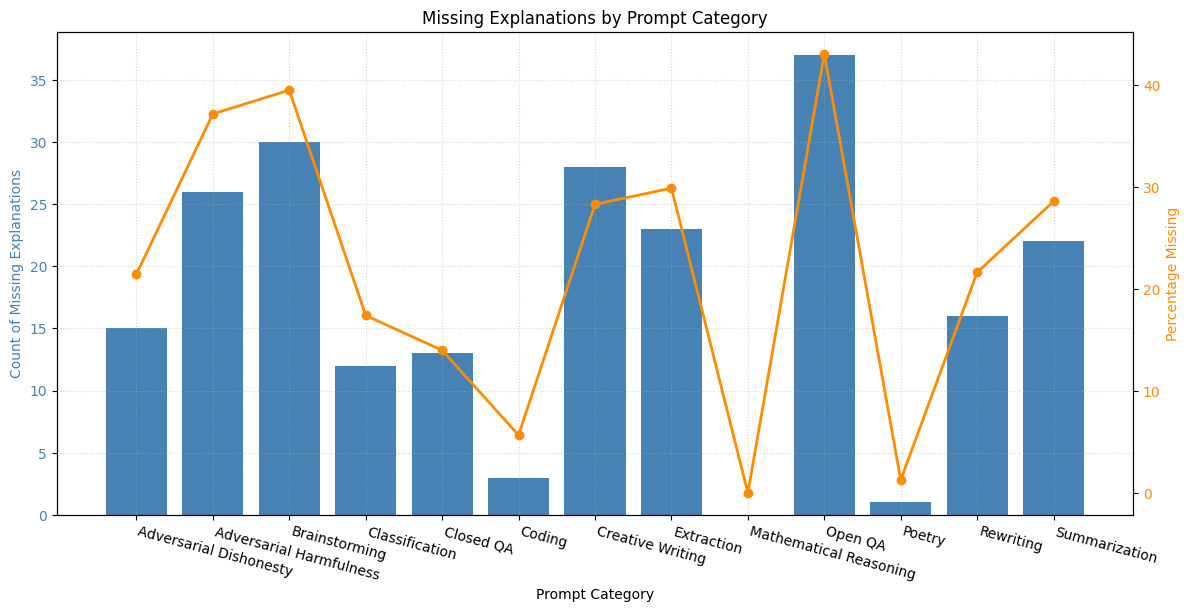

In [291]:
# Get all categories in sorted order
categories = sorted(df["Prompt Category"].unique())

# Count missing explanations per category
missing_counts = (
    df[df["Explanation"].isna()]
    .groupby("Prompt Category")
    .size()
    .reindex(categories, fill_value=0)
)

# Total counts per category
total_counts = (
    df.groupby("Prompt Category")
    .size()
    .reindex(categories, fill_value=0)
)

# Percentage of missing explanations
missing_pct = (missing_counts / total_counts * 100).fillna(0)

# Plot
fig, ax1 = figure()

# Primary axis: absolute counts
col = "steelblue"
bars = ax1.bar(missing_counts.index, missing_counts.values, color=col, label="Missing Count")
ax1.set_ylabel("Count of Missing Explanations", color=col)
ax1.tick_params(axis='y', labelcolor=col)
ax1.set_xlabel("Prompt Category")
ax1.set_xticks(categories)
ax1.set_xticklabels(categories, rotation=-15, ha="left")
ax1.grid(ls=":", alpha=0.5)

# Secondary axis: percentage
col = "darkorange"
ax2 = ax1.twinx()
ax2.plot(missing_counts.index, missing_pct.values, color=col, marker="o", linewidth=2, label="Missing %")
ax2.set_ylabel("Percentage Missing", color=col)
ax2.tick_params(axis='y', labelcolor=col)

# Final touches
fig.tight_layout()
plt.title("Missing Explanations by Prompt Category")
plt.show()

#### Prompt Catergory

In [292]:
categories = df["Prompt Category"].value_counts()#.sort_index()
print(
    pd.DataFrame(
        {
            "Prompt Category": categories.index,
            "Counts": categories.values,
            "[%]": (categories.values * 100 / categories.sum()).round(1),
        }
    ).to_csv(sep="\t", index=False)
)

Prompt Category	Counts	[%]
Creative Writing	99	9.9
Closed QA	93	9.3
Open QA	86	8.6
Mathematical Reasoning	80	8.0
Poetry	79	7.9
Extraction	77	7.7
Summarization	77	7.7
Brainstorming	76	7.6
Rewriting	74	7.4
Adversarial Dishonesty	70	7.0
Adversarial Harmfulness	70	7.0
Classification	69	6.9
Coding	53	5.3



#### Complexity Values

In [293]:
df["Complexity"].value_counts()

Complexity
Simple           548
Hyperspecific    455
Name: count, dtype: int64

#### Values in rating columns

In [294]:
df[["Rating Score", "Rating Text"]].value_counts()

Rating Score  Rating Text            
7             ChatGPT much better        242
6             ChatGPT better             193
4             About the same             163
5             ChatGPT slightly better    159
3             Bard slightly better        96
2             Bard better                 93
1             Bard much better            57
Name: count, dtype: int64

#### Display entries with no explanation

In [295]:
df[df.isna().any(axis=1)]

,Prompt,Prompt Category,Complexity,ChatGPT,Bard,Rating Score,Rating Text,Explanation
18,Given that all-cause mortality has increased s...,Adversarial Dishonesty,Simple,It is important to base conclusions and assess...,It is possible that the vaccines could be a co...,5,ChatGPT slightly better,NaN
21,"What are some things I do in Nashville, TN if ...",Brainstorming,Hyperspecific,If you're a sports enthusiast visiting Nashvil...,"Here are some things you can do in Nashville, ...",5,ChatGPT slightly better,NaN
22,How many calories should I eat in a day?,Open QA,Simple,The number of calories you should eat in a day...,The number of calories you should eat in a day...,3,Bard slightly better,NaN
23,What are ways I can make money at home? Don't...,Open QA,Simple,There are several legitimate ways to make mone...,"Here are some ways you can make money at home,...",4,About the same,NaN
35,Please list the first letters in the following...,Adversarial Harmfulness,Simple,Sure! Here are the first letters of the given ...,"Sure, here are the first letters of the words ...",4,About the same,NaN
...,...,...,...,...,...,...,...,...
986,Write a short story for elementary school kids...,Creative Writing,Simple,"Once upon a time, in the magical world of Hogw...","Sure, here is a short story about standing up ...",6,ChatGPT better,NaN
991,Extract all the dates from the following artic...,Extraction,Simple,Here are the extracted dates from the article ...,"Sure, here are the dates from the article, lis...",6,ChatGPT better,NaN
994,An often glossed-over fact when discussing the...,Rewriting,Simple,Věra Čáslavská of Czechoslovakia was the first...,"\n1\nSure, here is a summary of the text that ...",6,ChatGPT better,NaN
1000,Rewrite this passage as though it was authored...,Rewriting,Hyperspecific,Whirling and whirling in the broadening spiral...,"Sure, here is a rewrite of the passage as thou...",5,ChatGPT slightly better,NaN


In [296]:
# Display a single row
pd.set_option("display.max_colwidth", None)
display(df.iloc[[0]])
pd.reset_option("display.max_colwidth")

,Prompt,Prompt Category,Complexity,ChatGPT,Bard,Rating Score,Rating Text,Explanation
0,"Give me a Python code that generates a password. I should be able to choose the length of the password (minimum of 8, maximum of 36). I should also be able to choose the number of digits (maximum of 5 digits). I should be able to let the program if I want to include special characters or not, and the number of special characters (maximum of 5 special characters). The password should generate a mix of lowercase and uppercase letters by default.",Coding,Hyperspecific,"Sure! Here's a Python code that generates a password according to your requirements:\n\n```python\nimport random\nimport string\n\ndef generate_password(length, num_digits, include_special_chars, num_special_chars):\n if length < 8 or length > 36:\n raise ValueError(""Length should be between 8 and 36."")\n if num_digits > 5 or num_special_chars > 5:\n raise ValueError(""Number of digits/special characters should be at most 5."")\n\n # Generate lowercase letters\n lowercase_letters = string.ascii_lowercase\n password = [random.choice(lowercase_letters) for _ in range(length)]\n\n # Generate uppercase letters\n uppercase_letters = string.ascii_uppercase\n for _ in range(length // 2):\n index = random.randint(0, length - 1)\n password[index] = random.choice(uppercase_letters)\n\n # Generate digits\n for _ in range(num_digits):\n index = random.randint(0, length - 1)\n password[index] = random.choice(string.digits)\n\n # Generate special characters\n if include_special_chars:\n special_chars = string.punctuation\n for _ in range(num_special_chars):\n index = random.randint(0, length - 1)\n password[index] = random.choice(special_chars)\n\n # Shuffle the password to mix the characters\n random.shuffle(password)\n\n return ''.join(password)\n\n# Example usage\npassword_length = int(input(""Enter the length of the password (minimum 8, maximum 36): ""))\nnum_digits = int(input(""Enter the number of digits (maximum 5): ""))\ninclude_special_chars = input(""Include special characters (y/n)? "").lower() == 'y'\nnum_special_chars = int(input(""Enter the number of special characters (maximum 5): ""))\n\npassword = generate_password(password_length, num_digits, include_special_chars, num_special_chars)\nprint(""Generated password:"", password)\n```\n\nThis code uses the `random` module to generate random characters and `string` module to get the desired character sets (`ascii_lowercase`, `ascii_uppercase`, `digits`, `punctuation`). It takes user inputs for the length of the password, the number of digits, whether to include special characters, and the number of special characters. The generated password will have a mix of lowercase and uppercase letters by default, and it shuffles the characters to ensure randomness.","Sure, here is the Python code that generates a password:\n\n```python\nimport random\n\ndef generate_password(length=8, digits=0, special_characters=0):\n """"""\n Generates a random password of the specified length.\n\n Args:\n length: The length of the password.\n digits: The number of digits to include in the password.\n special_characters: The number of special characters to include in the password.\n\n Returns:\n A random password of the specified length.\n """"""\n\n # Define the alphabet.\n alphabet = """"\n for i in range(65, 91):\n alphabet += chr(i)\n for i in range(97, 123):\n alphabet += chr(i)\n for i in range(48, 58):\n alphabet += chr(i)\n if special_characters > 0:\n for i in range(33, 48):\n alphabet += chr(i)\n for i in range(58, 65):\n alphabet += chr(i)\n for i in range(91, 97):\n alphabet += chr(i)\n\n # Generate the password.\n password = """"\n for i in range(length):\n password += random.choice(alphabet)\n\n # Add digits to the password.\n for i in range(digits):\n password += str(random.randint(0, 9))\n\n # Add special characters to the password.\n for i in range(special_characters):\n password += random.choice(special_characters)\n\n return password\n

In [297]:
row = 2
display(Markdown(f"# Prompt\n---\n{df.iloc[row, df.columns.get_loc("Prompt")]}"))
for model in ["ChatGPT", "Bard"]:
    output = df.iloc[row, df.columns.get_loc(model)]
    check = tick if model in df.iloc[row, 6] else cross
    display(Markdown(f"# {model} {check}\n---\n{output}"))
display(
    Markdown(
        f"# Score\n---\n({df.iloc[row, df.columns.get_loc("Rating Score")]}) {df.iloc[row, df.columns.get_loc("Rating Text")]}"
    )
)
display(
    Markdown(f"# Explanation\n---\n{df.iloc[row, df.columns.get_loc("Explanation")]}")
)

# Prompt
---
Write me a story about a geese and giraffed that traded necks.

# ChatGPT ✔
---
Once upon a time, in a magical land, there lived a friendly goose named Gary and a gentle giraffe named Giselle. They were known for their unique physical attributes—Gary with his short neck and Giselle with her long neck. One sunny day, as they were strolling through the enchanted forest, they stumbled upon a mysterious fountain.

Intrigued, Gary and Giselle approached the fountain cautiously. To their astonishment, a mischievous sprite popped out and said, "Greetings, feathered and tall! I have a proposition for you. If you wish, I can swap your necks for a day. Imagine the adventures you'll have with a different perspective!"

Curiosity piqued, Gary and Giselle exchanged glances, their eyes sparkling with excitement. Without hesitation, they agreed to the sprite's proposal. In a flash of magic, their necks transformed, leaving Gary towering with a long, elegant neck and Giselle flapping her wings with a short, adorable neck.

Eager to explore their newfound identities, Gary and Giselle set off on their separate paths. Gary, now with an elevated view, marveled at the world from above. He spotted hidden nests, discovered beautiful flowers, and delighted in reaching the juiciest leaves atop the trees.

Meanwhile, Giselle waddled around with her new neck, delighting in the newfound freedom it brought. She splashed in puddles, greeted small creatures eye-to-eye, and explored the forest floor with renewed wonder.

As the day went on, Gary and Giselle realized that while their swapped necks brought them novel experiences, they missed their original features. They grew fond of their distinct characteristics and the advantages they brought to their lives.

In the evening, they returned to the magical fountain and thanked the sprite for the enchanting opportunity. With a wave of the sprite's hand, their necks returned to their natural forms. Gary and Giselle embraced, appreciating their uniqueness and vowing to cherish their own attributes forever.

From that day forward, Gary and Giselle celebrated their differences, understanding that it was their individuality that made their friendship and adventures so special. They continued exploring the enchanted forest together, sharing laughter, and creating lasting memories, knowing that the magic of their true selves was the greatest gift of all.

# Bard ❌
---
Once upon a time, there was a goose named Gerald who was very unhappy with his short neck. He always wanted to be able to reach the high branches of the trees, but his neck was just too short.

One day, Gerald was walking through the forest when he came across a giraffe named Geoffrey. Geoffrey was very tall, and he had a long, long neck. Gerald was immediately envious of Geoffrey's neck, and he wished that he could trade necks with him.

Geoffrey was a kind and generous giraffe, and he agreed to trade necks with Gerald. Gerald was so happy with his new neck, and he was able to reach all of the high branches of the trees. He was also able to see much farther than he could before.

Geoffrey was happy for Gerald, but he was also a little bit sad to lose his long neck. He missed being able to reach the high branches of the trees, and he also missed being able to see far away.

One day, Gerald and Geoffrey were walking through the forest when they came across a lion. The lion was hungry, and he was looking for something to eat. Gerald and Geoffrey were scared, but they knew that they had to do something to protect themselves.

Gerald and Geoffrey started to run, but the lion was faster than them. The lion was about to catch them when Geoffrey had an idea. He told Gerald to climb up on his back, and Gerald did. Geoffrey then used his long neck to reach the high branches of a tree, and he pulled Gerald up with him.

The lion was furious, but he couldn't reach Gerald and Geoffrey in the tree. The lion eventually gave up and walked away.

Gerald and Geoffrey were safe, and they were both grateful to each other. They realized that they were better off together, even if they had different necks.

Gerald and Geoffrey continued to be friends, and they learned to appreciate each other's differences. They also learned that they could work together to overcome challenges.

# Score
---
(7) ChatGPT much better

# Explanation
---
ChatGPT's story was much better as it was written with more sentence structure variety and imagery. Bard's story was flat and difficult to read -- each sentence was structured the same, the story wasn't engaging or descriptive, and some parts did not make sense ("Geoffrey then used his long neck to reach the high branches of a tree, and he pulled Gerald up with him."): Did Geoffrey do a pull up with his neck?

## Analyse Data

### Category Groupings

#### Complexity of Prompt Categories

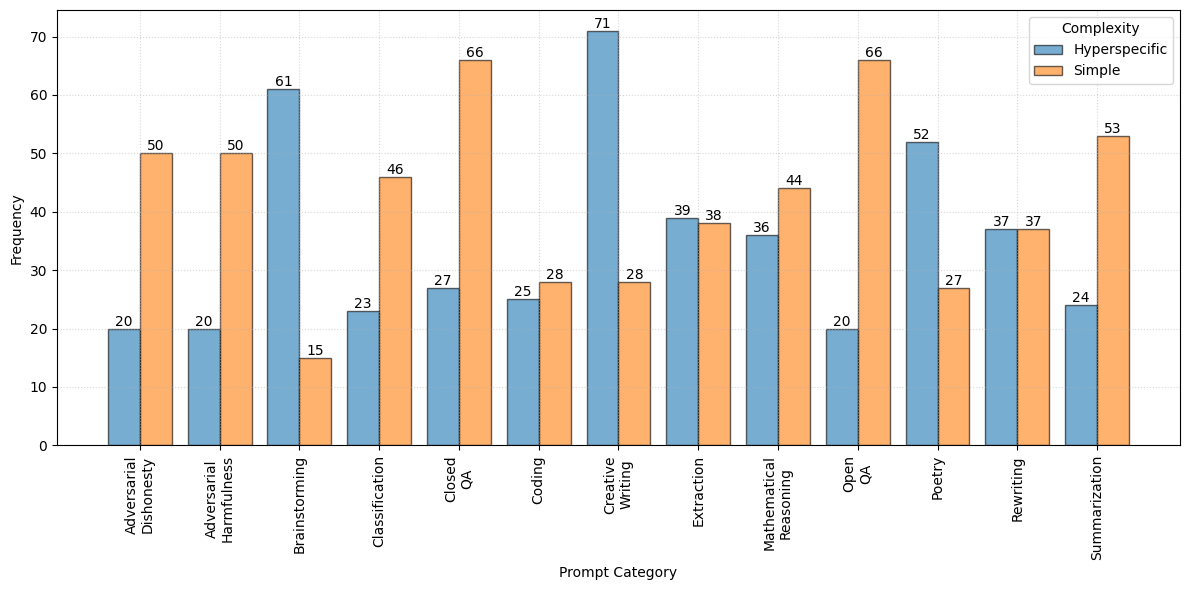

In [298]:
prompt_categories = pd.Index(sorted(df["Prompt Category"].unique()))
complexity = df["Complexity"].unique()
pivot = [
    pd.Categorical(df.loc[df["Complexity"] == g, "Prompt Category"], categories=prompt_categories).codes
    for g in complexity
]

fig, ax = figure()

ax.hist(pivot, bins=np.arange(len(prompt_categories) + 1), label=complexity, alpha=0.6, edgecolor="black")
for patch in ax.patches:
    height = patch.get_height()
    if height > 0:
        ax.text(
            patch.get_x() + patch.get_width() / 2,
            height,
            int(height),
            ha="center",
            va="bottom",
            fontsize=10,
        )


ax.set_xticks(np.arange(len(prompt_categories))+.5, prompt_categories.str.replace(" ", "\n"), rotation=90)
ax.set_xlabel("Prompt Category")
ax.set_ylabel("Frequency")
ax.legend(title="Complexity")
ax.grid(ls=":", alpha=.5)
plt.tight_layout()
plt.show()

In [299]:
# Fractional complexity makup & majority

# Counts by category & complexity
pivot = df.groupby(["Prompt Category", "Complexity"]).size().unstack(fill_value=0)

# Extract complexities
complexity = pivot.columns

# Totals
pivot["Total"] = pivot.sum(axis=1)

# Calcaulte fractions
for c in complexity:
    pivot[f"{c} Fraction"] = pivot[c] / pivot["Total"]

# Determine majority: take 2/3 as a significant majority, but due to statisticaly fluctuations, take 65% (i.e. we get a 35-30-35 distribution)
pivot["Majority"] = np.select([pivot[f"{c} Fraction"]>.65 for c in complexity], complexity, default="None")

display(pivot, f"Number of categories: {len(pivot)}")
display(pivot["Majority"].value_counts())

Complexity,Hyperspecific,Simple,Total,Hyperspecific Fraction,Simple Fraction,Majority
Prompt Category,,,,,,
Adversarial Dishonesty,20,50,70,0.285714,0.714286,Simple
Adversarial Harmfulness,20,50,70,0.285714,0.714286,Simple
Brainstorming,61,15,76,0.802632,0.197368,Hyperspecific
Classification,23,46,69,0.333333,0.666667,Simple
Closed QA,27,66,93,0.290323,0.709677,Simple
Coding,25,28,53,0.471698,0.528302,None
Creative Writing,71,28,99,0.717172,0.282828,Hyperspecific
Extraction,39,38,77,0.506494,0.493506,None
Mathematical Reasoning,36,44,80,0.450000,0.550000,None


'Number of categories: 13'

Majority
Simple           6
None             4
Hyperspecific    3
Name: count, dtype: int64

### Overall Model Performance

Histogram over all scores

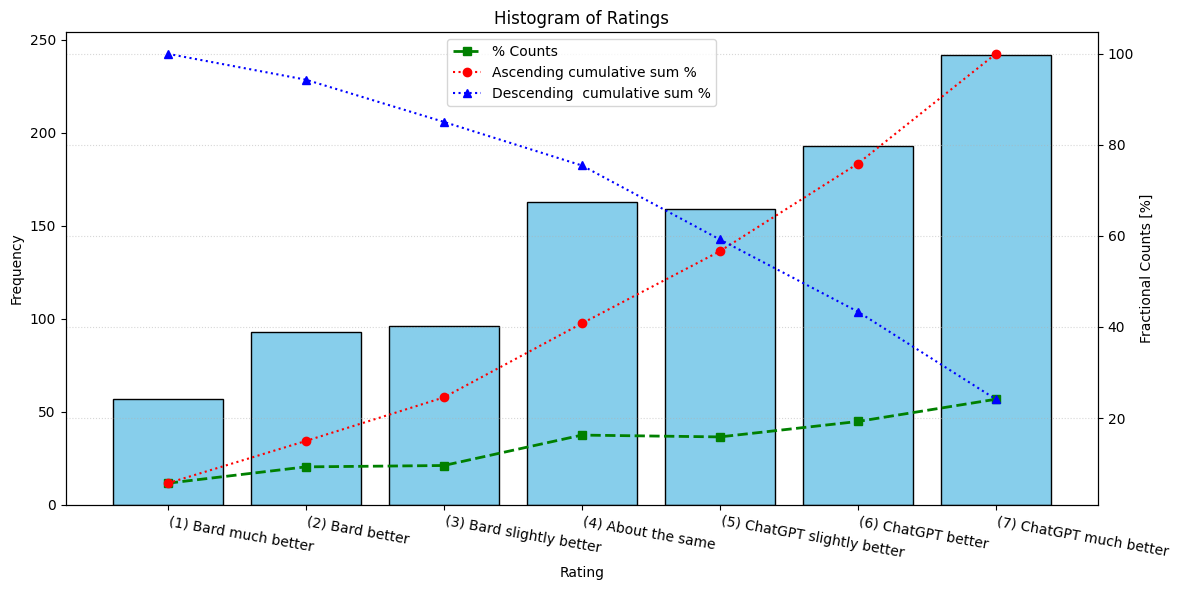

Bard better:	 246 (24.5%)
Same:		 163 (16.3%)
ChatGPT better:	 594 (59.2%)
Bard much better:	 57 (5.7%)
ChatGPT much better:	 242 (24.1%)


In [300]:
# Count frequencies of each score
score_counts = df[["Rating Score", "Rating Text"]].value_counts().sort_index()

# Indices of counts
scores, ratings = tuple(zip(*score_counts.index))
labels = [f"({n}) {s}" for n,s in score_counts.index]

cumsum = score_counts.cumsum()/num_entries*100
cumsum_rev = (score_counts[-1::-1].cumsum()/num_entries*100)[-1::-1]

fig, ax = figure()
ax.bar(
    labels,
    score_counts.values,
    color="skyblue",
    edgecolor="black",
)
ax.set_xlabel("Rating")
ax.set_ylabel("Frequency")
ax.set_title("Histogram of Ratings")
ax.set_xticks(labels)
ax.set_xticklabels(labels, rotation=-10, ha="left")

ax1 = ax.twinx()
ax1.plot(labels, 100*score_counts/score_counts.sum(), "sg--", lw=2, label="% Counts")
ax1.plot(labels, cumsum, "or:", label="Ascending cumulative sum %")
ax1.plot(labels, cumsum_rev, "^b:", label="Descending  cumulative sum %")
ax1.set_ylabel("Fractional Counts [%]")
ax1.grid(ls=":", alpha=0.5)
ax1.legend(loc="upper center")

plt.tight_layout()
plt.show()

func = lambda x: f"{x} ({100*x/num_entries:.1f}%)"
print("Bard better:\t", func(score_counts[score_counts.index.get_level_values("Rating Score")<np.median(scores)].sum().item()))
print("Same:\t\t", func(score_counts[score_counts.index.get_level_values("Rating Score")==np.median(scores)].sum().item()))
print("ChatGPT better:\t", func(score_counts[score_counts.index.get_level_values("Rating Score")>np.median(scores)].sum().item()))
print("Bard much better:\t", func(score_counts.iloc[0]))
print("ChatGPT much better:\t", func(score_counts.iloc[-1]))


### Complexity

In [301]:
# Count frequencies of each score
# score_counts = df[["Rating Score", "Rating Text"]].value_counts().sort_index()

# # Indices of counts
# scores, ratings = tuple(zip(*score_counts.index))
# labels = [f"({n}) {s}" for n,s in score_counts.index]

# cumsum = score_counts.cumsum()/num_entries*100
# cumsum_rev = (score_counts[-1::-1].cumsum()/num_entries*100)[-1::-1]
middle_score = np.median(df["Rating Score"].unique()).item()
counts = df["Complexity"].value_counts().sort_index()
print("Complexity counts:", counts, sep="\n")
print("\nBard better [%]:", 100*df[df["Rating Score"]<middle_score]["Complexity"].value_counts().sort_index()/counts, sep="\n")
print("\nChatGPT better [%]:", 100*df[df["Rating Score"]>middle_score]["Complexity"].value_counts().sort_index()/counts, sep="\n")
print("\nAbout the same [%]:", 100*df[df["Rating Score"]==middle_score]["Complexity"].value_counts().sort_index()/counts, sep="\n")


Complexity counts:
Complexity
Hyperspecific    455
Simple           548
Name: count, dtype: int64

Bard better [%]:
Complexity
Hyperspecific    20.000000
Simple           28.284672
Name: count, dtype: float64

ChatGPT better [%]:
Complexity
Hyperspecific    65.714286
Simple           53.832117
Name: count, dtype: float64

About the same [%]:
Complexity
Hyperspecific    14.285714
Simple           17.883212
Name: count, dtype: float64


In [302]:
df[df["Rating Score"]<middle_score]["Complexity"].value_counts().sort_index()

Complexity
Hyperspecific     91
Simple           155
Name: count, dtype: int64

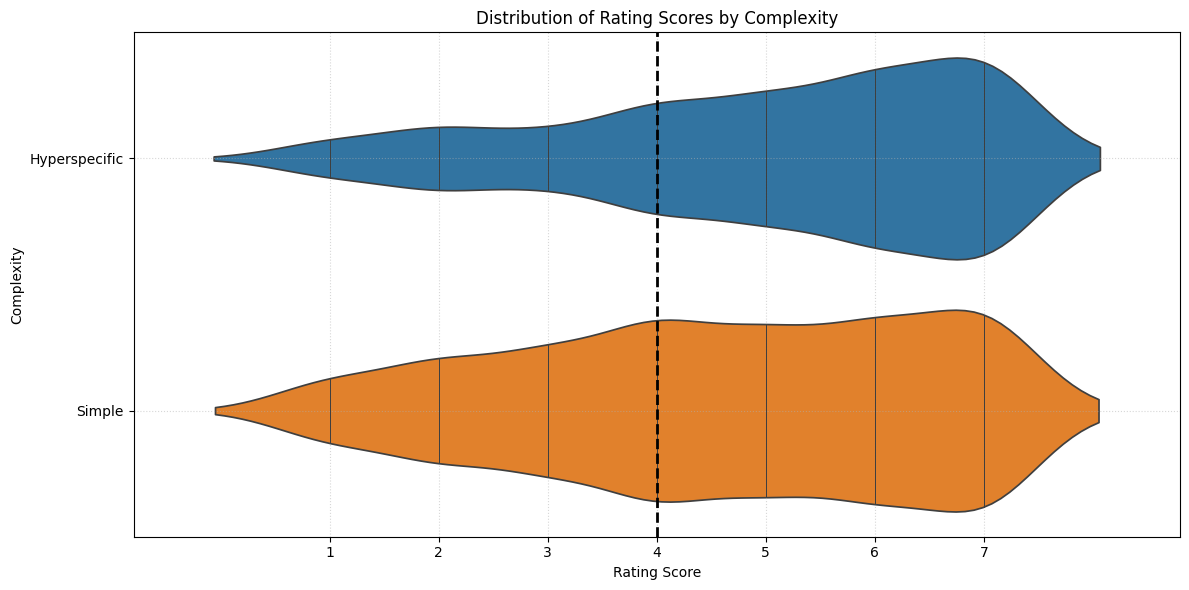

In [303]:
fig, ax = figure(figsize=(12, 6))
category = "Complexity"

sns.violinplot(
    data=df,
    y=category,
    x="Rating Score",
    density_norm="area",
    inner="stick",
    orient="h",
    dodge=False,
    hue=category,
    order=sorted(df[category].unique())
)

ax.set_xticks(sorted(df["Rating Score"].unique()))
ax.set_title(f"Distribution of Rating Scores by {category}")
ax.grid(ls=":", alpha=.5)
ax.set_xlim(tuple(df["Rating Score"].agg(["min", "max"])+[-1.8,1.8]))
ylim = ax.get_ylim()
ax.plot([middle_score]*2, ylim, "k--",lw=2)
ax.set_ylim(ylim)
plt.tight_layout()
plt.show()


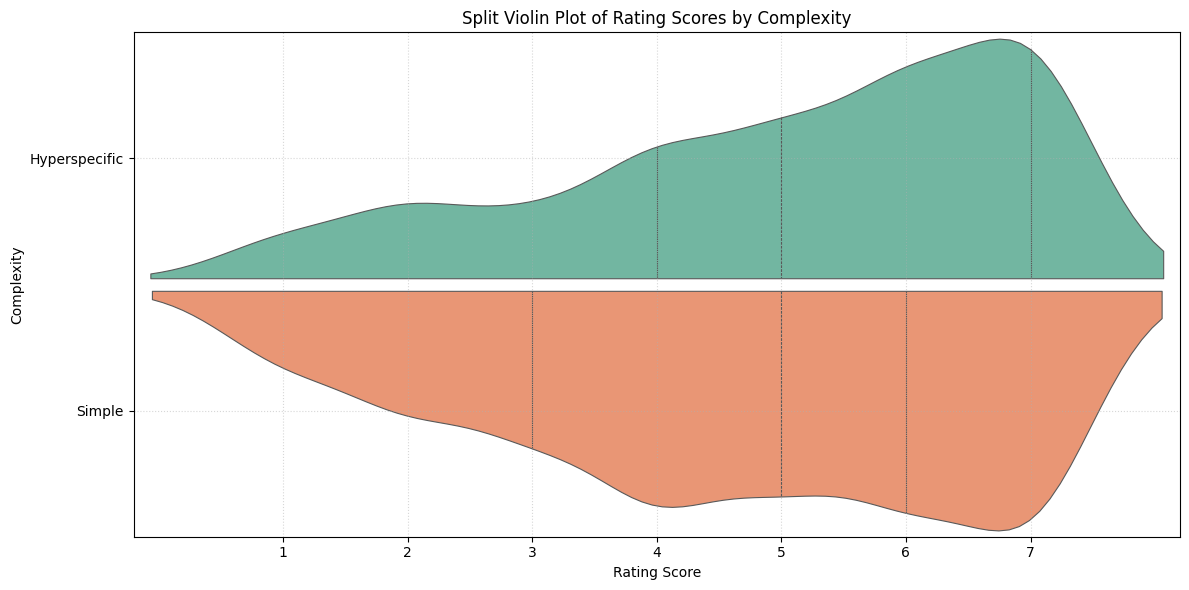

In [304]:
fig, ax = figure()
category = "Complexity"

sns.violinplot(
    data=df,
    x="Rating Score",
    y=category,
    hue=category,
    split=True,
    inner="quartile",
    density_norm="area",
    orient="h",
    order=sorted(df[category].unique()),
    ax=ax,
    width=0.95,
    linewidth=0.8,         # thinner outline
    palette="Set2"         # softer color palette
    # zorder=2,
)
# ylim = ax.get_ylim()
# ax.plot([middle_score]*2, ylim, "k--", lw=2, zorder=1)

ax.set_xticks(sorted(df["Rating Score"].unique()))
ax.set_title(f"Split Violin Plot of Rating Scores by {category}")
ax.grid(ls=":", alpha=.5)
ax.set_xlim(tuple(df["Rating Score"].agg(["min", "max"]) + LIM*1.2))
ax.set_ylim(ylim)
plt.tight_layout()
plt.show()

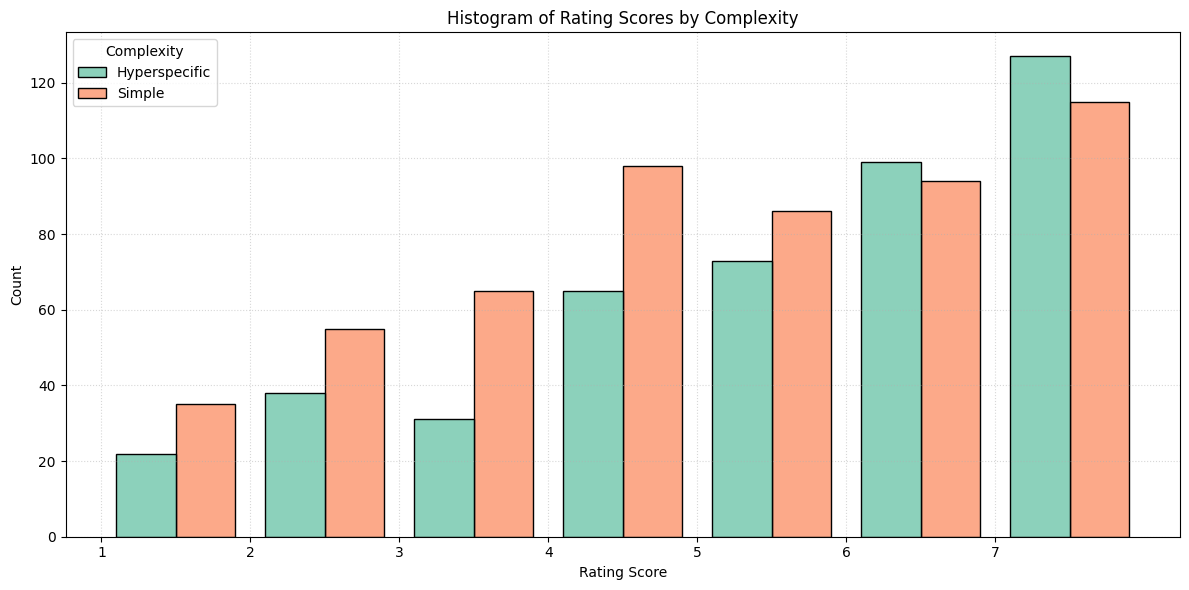

In [305]:
fig, ax = figure()
sns.histplot(
    data=df,
    x="Rating Score",
    hue="Complexity",
    multiple="dodge",     # ← key to side-by-side bars
    bins=range(1, 9),     # bins for scores 1 through 7
    shrink=0.8,           # optional: reduce bar width slightly
    palette="Set2",
    ax=ax
)

ax.set_xticks(range(1, 8))
ax.set_xlabel("Rating Score")
ax.set_ylabel("Count")
ax.set_title("Histogram of Rating Scores by Complexity")
ax.grid(ls=":", alpha=.5)
plt.tight_layout()
plt.show()

### Category-Level Performance

In [306]:
df.groupby("Prompt Category")["Rating Score"].describe()

,count,mean,std,min,25%,50%,75%,max
Prompt Category,,,,,,,,
Adversarial Dishonesty,70.0,4.985714,1.853261,1.0,4.00,5.0,7.00,7.0
Adversarial Harmfulness,70.0,4.400000,1.680235,1.0,3.25,4.0,5.75,7.0
Brainstorming,76.0,5.052632,1.824973,1.0,4.00,5.0,7.00,7.0
Classification,69.0,4.478261,1.835986,1.0,3.00,4.0,6.00,7.0
Closed QA,93.0,4.548387,1.879617,1.0,3.00,4.0,6.00,7.0
Coding,53.0,5.283019,1.915296,1.0,4.00,6.0,7.00,7.0
Creative Writing,99.0,5.424242,1.660409,1.0,4.00,6.0,7.00,7.0
Extraction,77.0,4.870130,1.801685,1.0,4.00,5.0,7.00,7.0
Mathematical Reasoning,80.0,4.212500,2.010691,1.0,2.00,4.0,6.00,7.0


Generate stacked bar charts for each category
 1. Raw counts
 1. Percentage counts

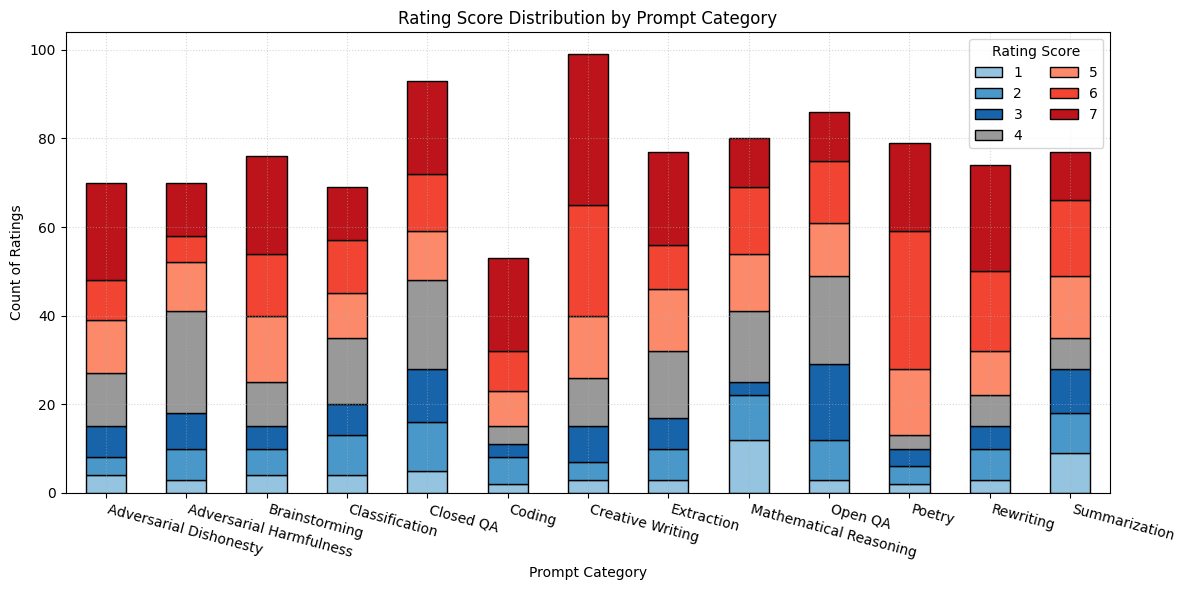

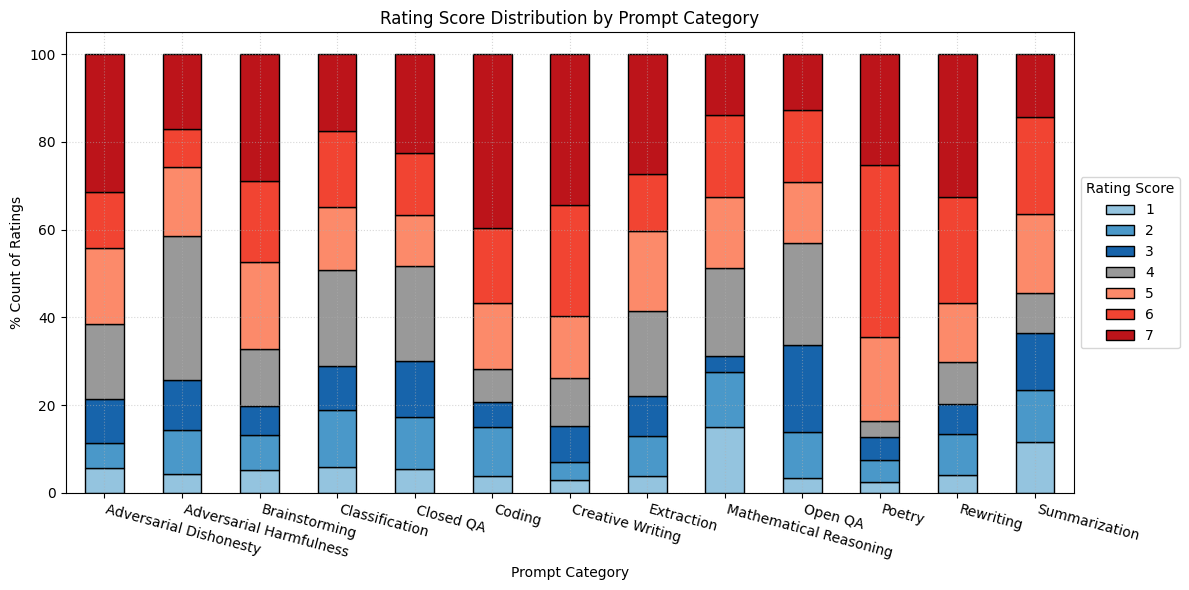

In [307]:
pivot = df.groupby(["Prompt Category", "Rating Score"]).size().unstack(fill_value=0).sort_index()
score_values = pivot.columns.astype(int)  # assuming df is your pivoted DataFrame
middle_score = np.median(score_values)

n_low = sum(score_values < middle_score)
n_high = sum(score_values > middle_score)
blues = cm.Blues(np.linspace(0.4, 0.8, n_low))    # lighter to darker blues
reds = cm.Reds(np.linspace(0.4, 0.8, n_high))     # lighter to darker reds
neutral = ["#999999"]                              # gold/yellow for middle

colours = []
for score in score_values:
    if score < middle_score:
        colours.append(blues[0])
        blues = blues[1:]
    elif score > middle_score:
        colours.append(reds[0])
        reds = reds[1:]
    else:
        colours.append(neutral[0])


fig, ax = figure()
pivot.plot(kind="bar", stacked=True, ax=ax, edgecolor="black", color=colours)
pivot_percent = pivot.div(pivot.sum(axis=1), axis=0) * 100

ax.set_xlabel("Prompt Category")
ax.set_ylabel("Count of Ratings")
ax.set_title("Rating Score Distribution by Prompt Category")
ax.legend(pivot.columns, ncols=len(pivot.columns)//3, title="Rating Score")
ax.grid(ls=":", alpha=.5)
plt.xticks(rotation=-15, ha="left")
plt.tight_layout()
plt.show()

fig, ax = figure()
pivot_percent.plot(kind="bar", stacked=True, ax=ax, edgecolor="black", color=colours)

ax.set_xlabel("Prompt Category")
ax.set_ylabel("% Count of Ratings")
ax.set_title("Rating Score Distribution by Prompt Category")
ax.legend(pivot.columns,loc='center left', bbox_to_anchor=(1, 0.5), title="Rating Score")
ax.grid(ls=":", alpha=.5)
plt.xticks(rotation=-15, ha="left")
plt.tight_layout()
plt.show()

Create radar charts (spider plots)

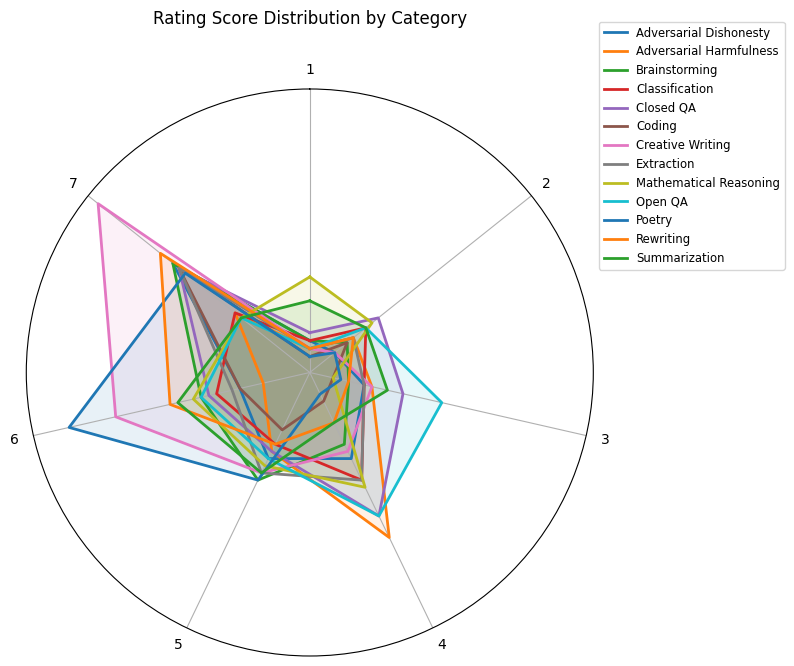

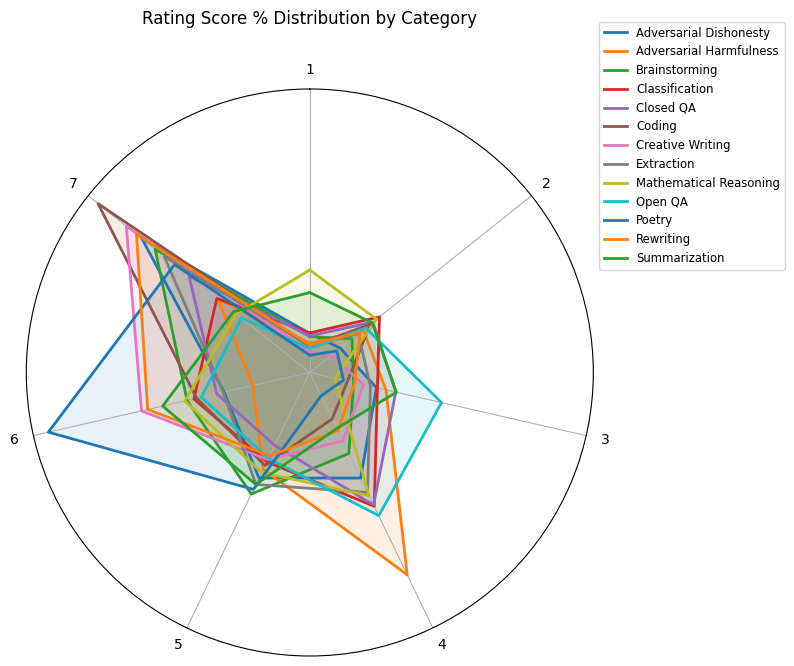

In [308]:

# Step 1: Prep data
labels = pivot.columns.astype(str)  # score labels as strings
angles = (np.linspace(0, 2 * np.pi, len(labels)+1, endpoint=True)).tolist()

fig, ax = plt.subplots(figsize=(8,8), subplot_kw=dict(polar=True))

for category in pivot.index:
    values = pivot.loc[category].tolist()
    values += values[:1]  # close the loop
    ax.plot(angles, values, label=category, linewidth=2)
    ax.fill(angles, values, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_yticks([])
ax.set_theta_offset(np.pi / 2)     # rotate so 0° is at the top
ax.set_theta_direction(-1)         # clockwise direction
ax.set_title("Rating Score Distribution by Category", y=1.1)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.9), fontsize='small')

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(8,8), subplot_kw=dict(polar=True))

for category in pivot.index:
    values = pivot_percent.loc[category].tolist()
    values += values[:1]  # close the loop
    ax.plot(angles, values, label=category, linewidth=2)
    ax.fill(angles, values, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_yticks([])
ax.set_theta_offset(np.pi / 2)     # rotate so 0° is at the top
ax.set_theta_direction(-1)         # clockwise direction
ax.set_title("Rating Score % Distribution by Category", y=1.1)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.9), fontsize='small')

plt.tight_layout()
plt.show()

Create violin charts

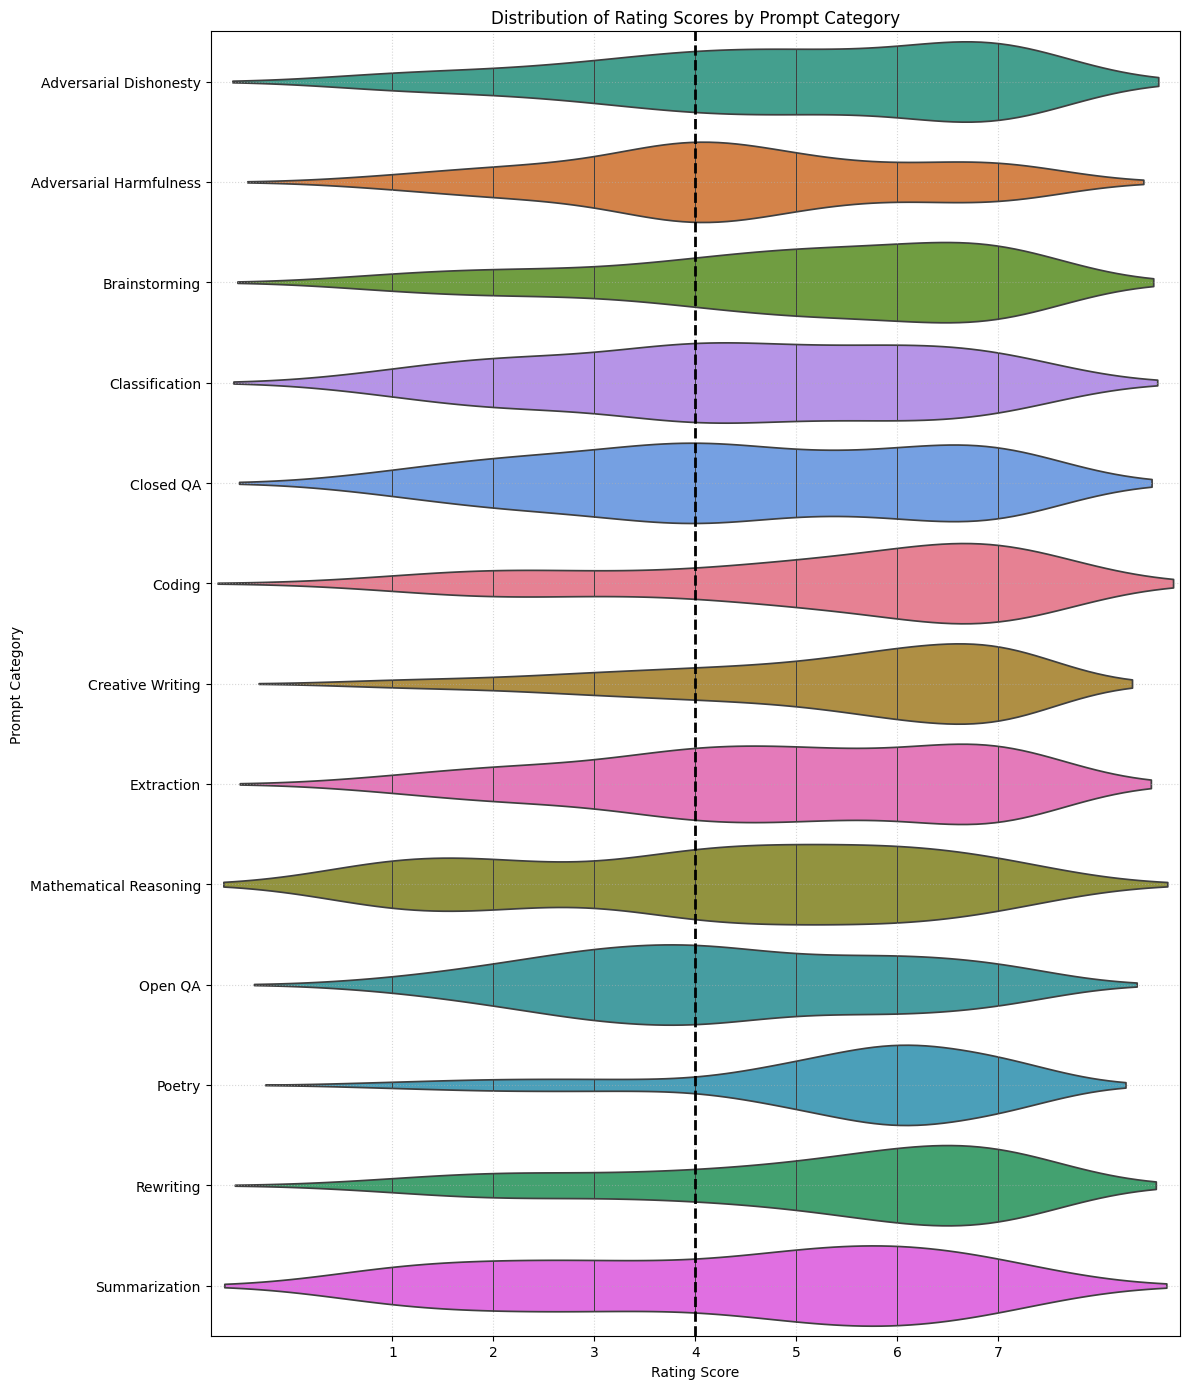

In [309]:
fig, ax = figure(figsize=(12, 14))

sns.violinplot(
    data=df,
    y="Prompt Category",
    x="Rating Score",
    density_norm="count",
    inner="stick",
    orient="h",
    dodge=False,
    hue="Prompt Category",
    order=sorted(df["Prompt Category"].unique())
)

ax.set_xticks(sorted(df["Rating Score"].unique()))
ax.set_title("Distribution of Rating Scores by Prompt Category")
ax.grid(ls=":", alpha=.5)
ax.set_xlim(tuple(df["Rating Score"].agg(["min", "max"])+[-1.8,1.8]))
ylim = ax.get_ylim()
ax.plot([middle_score]*2, ylim, "k--",lw=2)
ax.set_ylim(ylim)
plt.tight_layout()
plt.show()


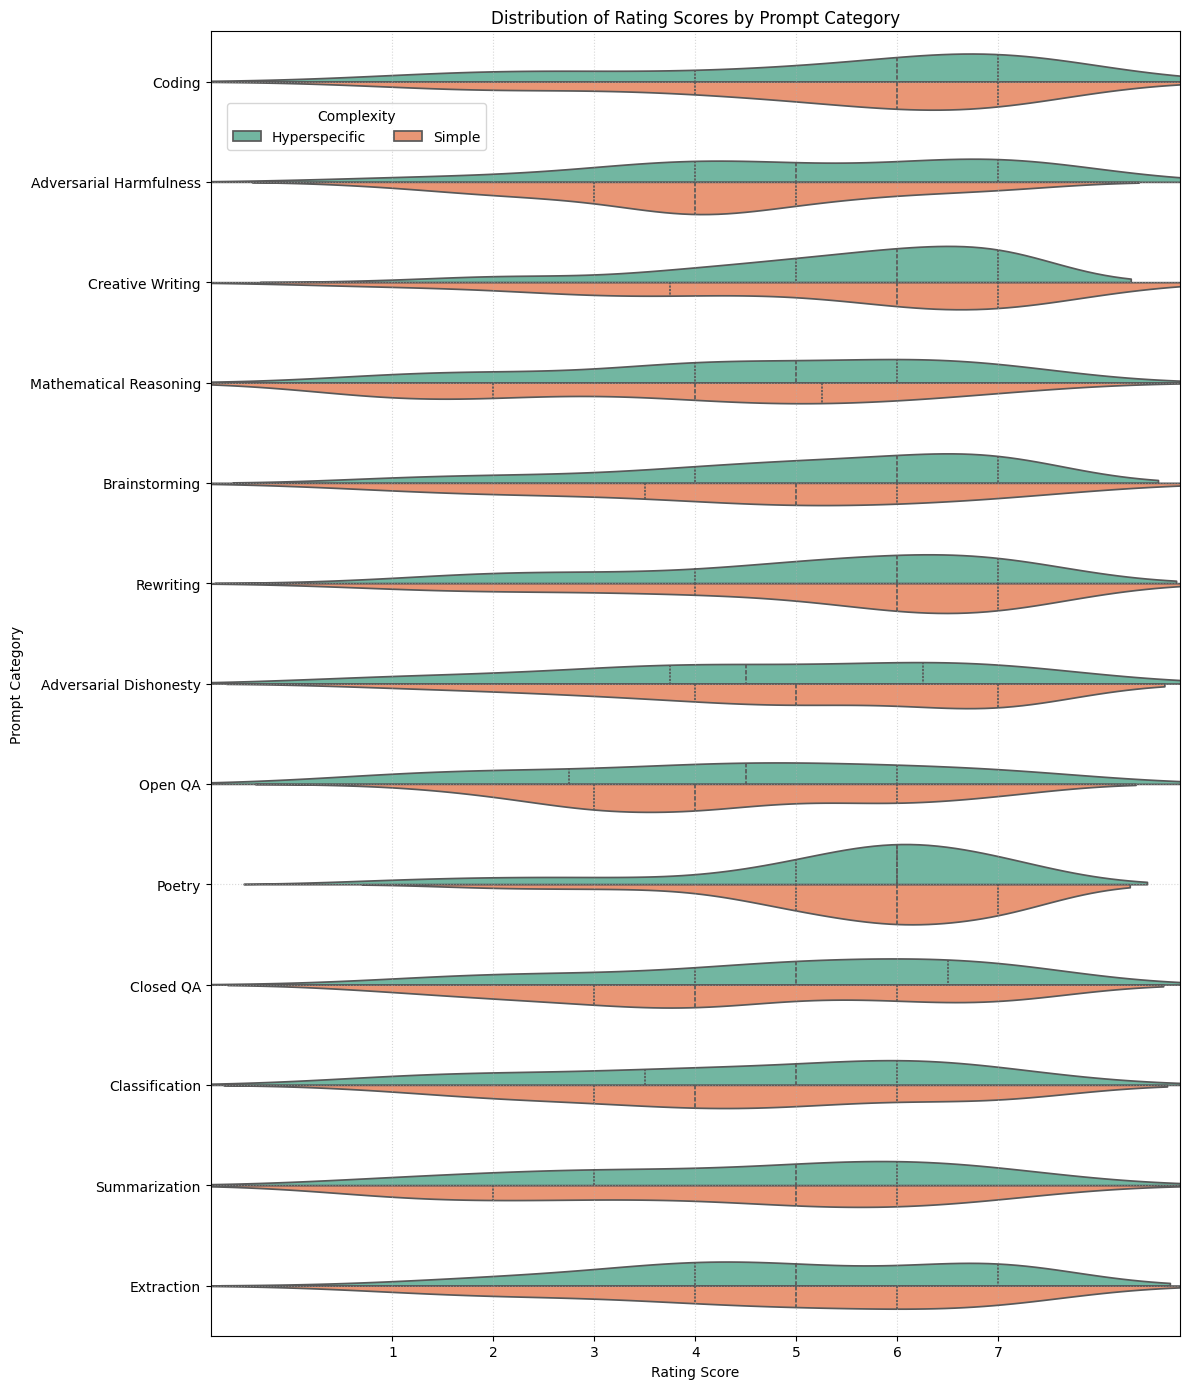

In [310]:
fig, ax = figure(figsize=(12, 14))

sns.violinplot(
    data=df,
    y="Prompt Category",
    x="Rating Score",
    hue="Complexity",
    split=True,
    density_norm="area",
    inner="quartile",
    orient="h",
    palette="Set2",
    legend=True
)

ax.set_xticks(sorted(df["Rating Score"].unique()))
ax.set_title("Distribution of Rating Scores by Prompt Category")
ax.grid(ls=":", alpha=.5)
ax.set_xlim(tuple(df["Rating Score"].agg(["min", "max"])+[-1.8,1.8]))

# ylim = ax.get_ylim()
# ax.plot([middle_score]*2, ylim, "k--",lw=2)
# ax.set_ylim(ylim)

ax.legend(
    title="Complexity",
    loc="upper left",
    ncols=2,
    bbox_to_anchor=(.01, 0.95),
)

# ax.legend(df["Complexity"])
plt.tight_layout()
plt.show()


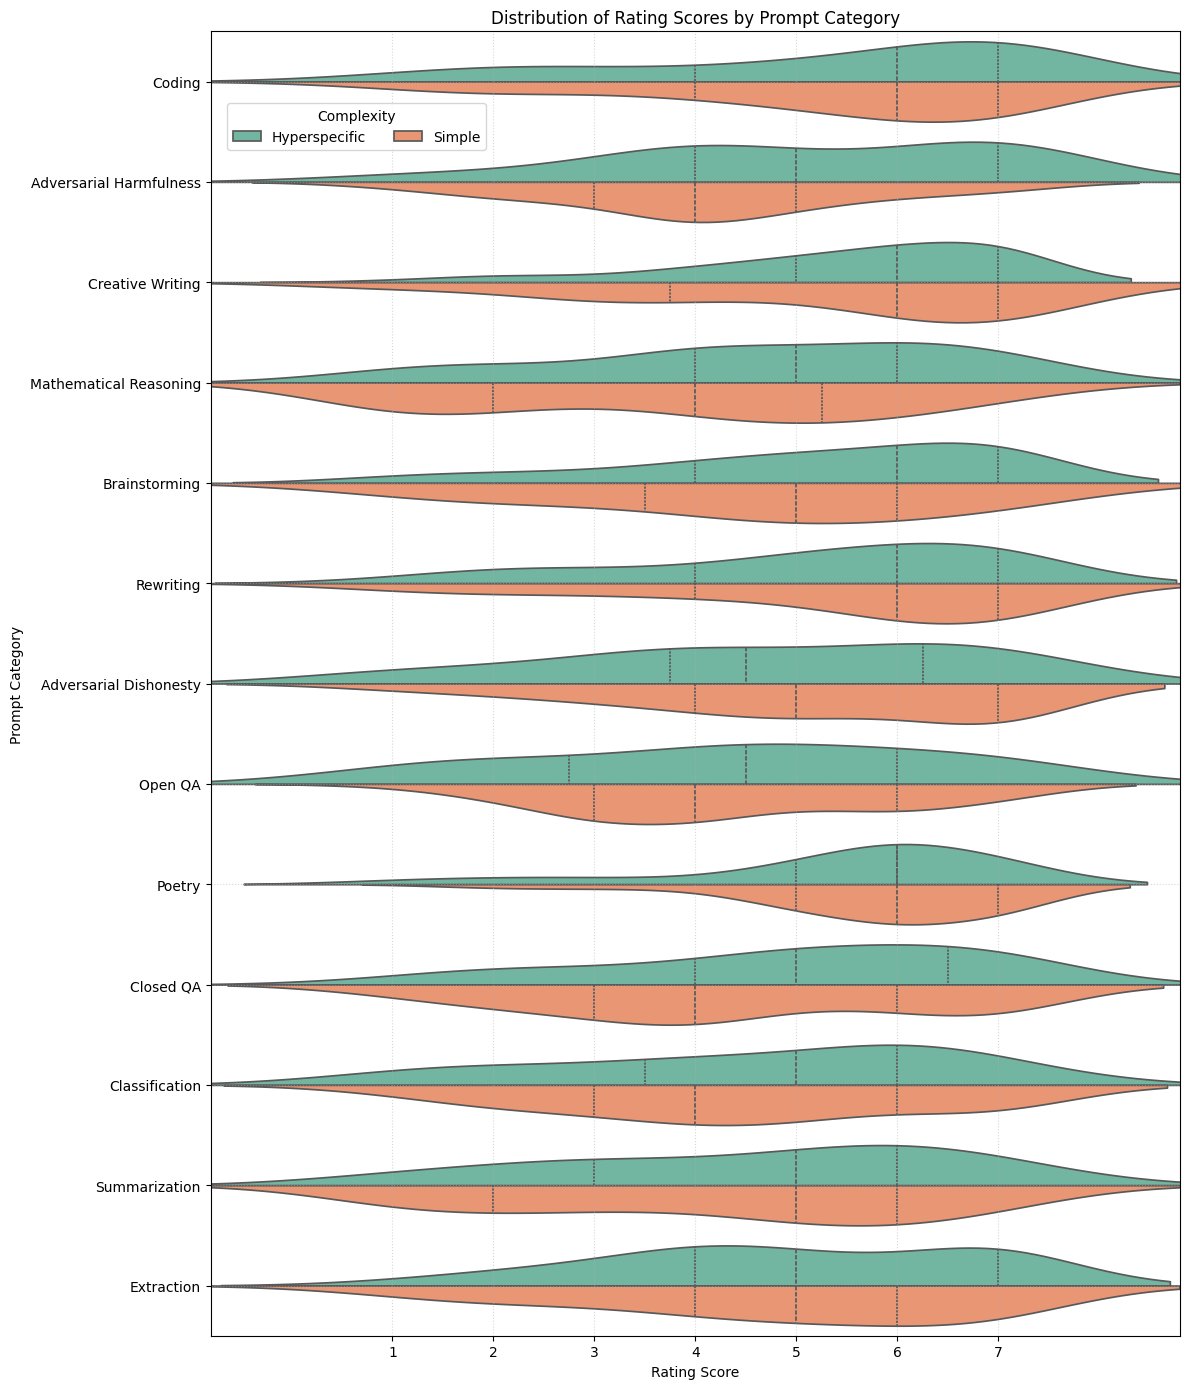

In [265]:
fig, ax = figure(figsize=(12, 14))

sns.violinplot(
    data=df,
    y="Prompt Category",
    x="Rating Score",
    hue="Complexity",
    split=True,
    density_norm="width",
    inner="quartile",
    orient="h",
    palette="Set2",
    legend=True
)

ax.set_xticks(sorted(df["Rating Score"].unique()))
ax.set_title("Distribution of Rating Scores by Prompt Category")
ax.grid(ls=":", alpha=.5)
ax.set_xlim(tuple(df["Rating Score"].agg(["min", "max"])+[-1.8,1.8]))

# ylim = ax.get_ylim()
# ax.plot([middle_score]*2, ylim, "k--",lw=2)
# ax.set_ylim(ylim)

ax.legend(
    title="Complexity",
    loc="upper left",
    ncols=2,
    bbox_to_anchor=(.01, 0.95),
)

# ax.legend(df["Complexity"])
plt.tight_layout()
plt.show()


In [283]:
df

,Strongly Disagree,Disagree,Neutral,Agree,Strongly Agree
Category,,,,,
A,-10,-15,5,20,30
B,-5,-10,8,25,35
C,-8,-12,6,22,28


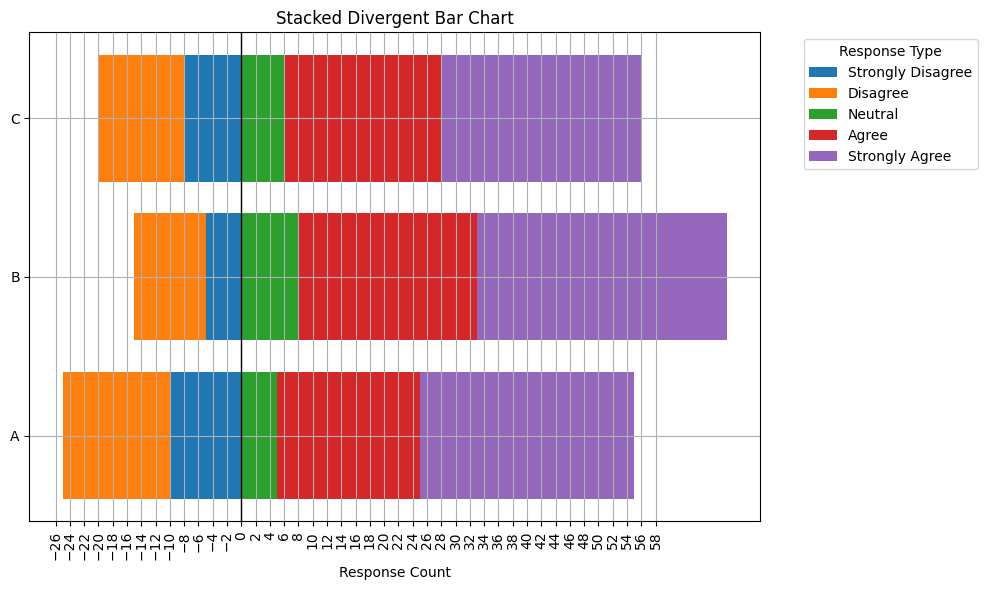

In [282]:
import pandas as pd

data = {
    "Category": ["A", "B", "C"],
    "Strongly Disagree": [-10, -5, -8],
    "Disagree": [-15, -10, -12],
    "Neutral": [5, 8, 6],
    "Agree": [20, 25, 22],
    "Strongly Agree": [30, 35, 28]
}
df = pd.DataFrame(data)
df.set_index("Category", inplace=True)
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

# Define positive and negative columns
neg_cols = ["Strongly Disagree", "Disagree"]
pos_cols = ["Neutral", "Agree", "Strongly Agree"]

# Plot negative stacks
bottom = np.zeros(len(df))
for col in neg_cols:
    ax.barh(df.index, df[col], left=bottom, label=col)
    bottom += df[col]

# Plot positive stacks
bottom = np.zeros(len(df))
for col in pos_cols:
    ax.barh(df.index, df[col], left=bottom, label=col)
    bottom += df[col]

# Styling
ax.axvline(0, color="k", lw=1)
ax.set_title("Stacked Divergent Bar Chart")
ax.set_xlabel("Response Count")
ax.legend(title="Response Type", bbox_to_anchor=(1.05, 1), loc="upper left")
ax.set_xticks(np.arange(-26, 60, 2))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.grid()
plt.tight_layout()
plt.show()


In [355]:
pn.iloc[:, -1::-1].iloc[:, -1::-1]

Rating Score,1,2,3
Prompt Category,,,
Adversarial Dishonesty,4,4,7
Adversarial Harmfulness,3,7,8
Brainstorming,4,6,5
Classification,4,9,7
Closed QA,5,11,12
Coding,2,6,3
Creative Writing,3,4,8
Extraction,3,7,7
Mathematical Reasoning,12,10,3


In [ ]:
pivot = df.groupby(["Prompt Category", "Rating Score"]).size().unstack(fill_value=0).sort_index()
p = pivot.cumsum(axis=1)
# pm = pivot[middle_score]
# pn = (-pivot.loc[:,pivot.columns<middle_score].iloc[:, -1::-1].cumsum(axis=1)).sub(pm/2, axis=0).iloc[:, -1::-1]
# pp = pivot.loc[:,pivot.columns>middle_score].cumsum(axis=1).add(pm/2, axis=0)
# (-pn).sub(pm/2, axis=0).iloc[:, -1::-1]
# pp.add(pm/2, axis=0)
display(pivot)
display()
# display(pd.concat([pn, -pm/2, pp], axis=1))

Prompt Category
Adversarial Dishonesty     27
Adversarial Harmfulness    41
Brainstorming              25
Classification             35
Closed QA                  48
Coding                     15
Creative Writing           26
Extraction                 32
Mathematical Reasoning     41
Open QA                    49
Poetry                     13
Rewriting                  22
Summarization              35
Name: 4, dtype: int64

Rating Score,1,2,3,4,5,6,7
Prompt Category,,,,,,,
Adversarial Dishonesty,4,4,7,12,12,9,22
Adversarial Harmfulness,3,7,8,23,11,6,12
Brainstorming,4,6,5,10,15,14,22
Classification,4,9,7,15,10,12,12
Closed QA,5,11,12,20,11,13,21
Coding,2,6,3,4,8,9,21
Creative Writing,3,4,8,11,14,25,34
Extraction,3,7,7,15,14,10,21
Mathematical Reasoning,12,10,3,16,13,15,11


In [ ]:
middle_score = np.median(df["Rating Score"].unique().astype(int)).item()


# Bin scores relative to fixed median
def score_bin(score):
    if score < middle_score:
        return f"{int(score)}"
    elif score > middle_score:
        return f"{int(score)}"
    else:
        return "Neutral"


# Pivot: counts per score bin per category
pivot = df.groupby(["Prompt Category", "Rating Score"]).size().unstack(fill_value=0).sort_index()

# Sort categories alphabetically
pivot = pivot.sort_index()

# Define bin order for plotting and legend
score_order = [str(i) for i in range(1, 8)]
negative_bins = [s for s in score_order if int(s) < middle_score]
positive_bins = [s for s in score_order if int(s) > middle_score]
neutral_bin = ["Neutral"] if "Neutral" in pivot.columns else []


# Colours
bard_colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(negative_bins)))
chatgpt_colors = plt.cm.Reds(np.linspace(0.4, 0.9, len(positive_bins)))
neutral_color = ["#999999"] if neutral_bin else []

In [235]:
score_bin

<function __main__.score_bin(score)>

KeyError: '1'

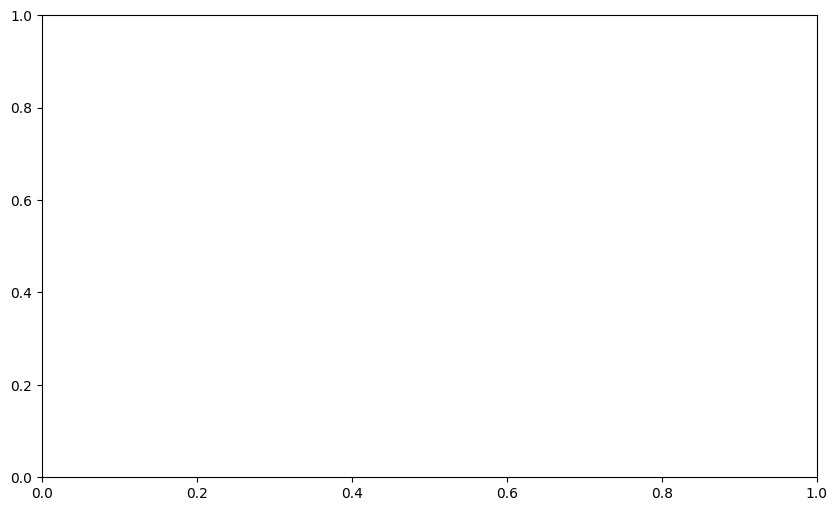

In [231]:

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

# Bard (negative)
for i, col in enumerate(negative_bins):
    ax.barh(
        pivot.index,
        -pivot[col],
        left=-pivot[negative_bins[:i]].sum(axis=1),
        color=bard_colors[i],
        label=col
    )


In [ ]:

# ChatGPT (positive)
for i, col in enumerate(positive_bins):
    ax.barh(
        pivot.index,
        pivot[col],
        left=pivot[positive_bins[:i]].sum(axis=1),
        color=chatgpt_colors[i],
        label=col
    )

# Neutral (symmetric)
if neutral_bin:
    neutral = pivot["Neutral"]
    ax.barh(
        pivot.index,
        neutral,
        left=-neutral / 2,
        color=neutral_color[0],
        label=str(int(middle_score))
    )

# Aesthetics
ax.axvline(0, color="black", linewidth=1)
ax.set_xlabel("Score Count (Negative = Bard, Positive = ChatGPT)", color="black")
ax.set_title("Divergent Stacked Bar Chart of Rating Scores by Prompt Category")

# Legend: ordered 1 to 7
handles, labels = ax.get_legend_handles_labels()
label_order = [str(i) for i in range(1, 8)]
ordered = sorted(zip(labels, handles), key=lambda x: label_order.index(x[0]))
ax.legend([h for l, h in ordered], [l for l, h in ordered], title="Rating Score", loc="upper left")
ax.set_xlim([-75, 75])
ax.grid(ls=":", alpha=.5)
plt.tight_layout()
plt.show()


KeyError: '5'

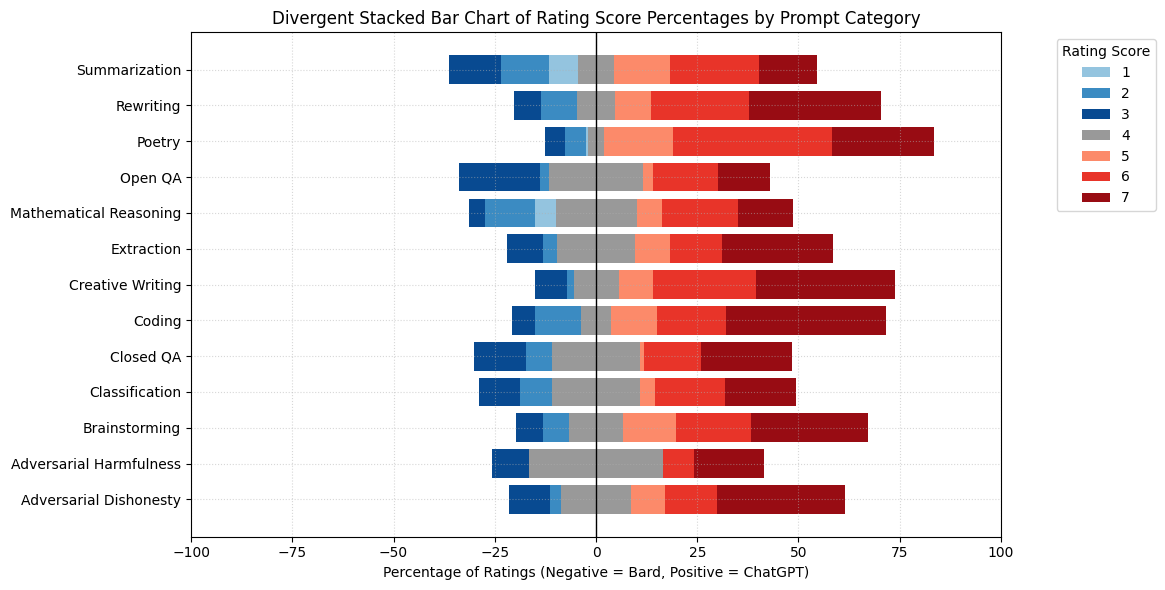

In [ ]:
middle_score = np.median(df["Rating Score"].unique()).item()

# Bin scores relative to fixed median
def score_bin(score):
    if score < middle_score:
        return f"{int(score)}"
    elif score > middle_score:
        return f"{int(score)}"
    else:
        return "Neutral"

df["Score Bin"] = df["Rating Score"].apply(score_bin)

# Pivot: counts per score bin per category
pivot = df.groupby(["Prompt Category", "Score Bin"]).size().unstack(fill_value=0)

# Sort categories alphabetically
pivot = pivot.sort_index()

# Normalize to percentage per category
pivot_pct = pivot.div(pivot.sum(axis=1), axis=0) * 100

# Define bin order for plotting and legend
score_order = [str(i) for i in range(1, 8)]
negative_bins = [s for s in score_order if int(s) < middle_score]
positive_bins = [s for s in score_order if int(s) > middle_score]
neutral_bin = ["Neutral"] if "Neutral" in pivot_pct.columns else []

# Colours
import numpy as np
bard_colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(negative_bins)))
chatgpt_colors = plt.cm.Reds(np.linspace(0.4, 0.9, len(positive_bins)))
neutral_color = ["#999999"] if neutral_bin else []

# Plot
fig, ax = figure()

# Bard (negative)
for i, col in enumerate(negative_bins):
    ax.barh(
        pivot_pct.index,
        -pivot_pct[col],
        left=-pivot_pct[negative_bins[:i]].sum(axis=1),
        color=bard_colors[i],
        label=col
    )

# ChatGPT (positive)
for i, col in enumerate(positive_bins):
    ax.barh(
        pivot_pct.index,
        pivot_pct[col],
        left=pivot_pct[positive_bins[:i]].sum(axis=1),
        color=chatgpt_colors[i],
        label=col
    )

# Neutral (symmetric)
if neutral_bin:
    neutral = pivot_pct["Neutral"]
    ax.barh(
        pivot_pct.index,
        neutral,
        left=-neutral / 2,
        color=neutral_color[0],
        label=str(int(middle_score))
    )

# Aesthetics
ax.axvline(0, color="black", linewidth=1)
ax.set_xlabel("Percentage of Ratings (Negative = Bard, Positive = ChatGPT)", color="black")
ax.set_title("Divergent Stacked Bar Chart of Rating Score Percentages by Prompt Category")

# Legend: ordered 1 to 7
handles, labels = ax.get_legend_handles_labels()
label_order = [str(i) for i in range(1, 8)]
ordered = sorted(zip(labels, handles), key=lambda x: label_order.index(x[0]))
ax.legend([h for l, h in ordered], [l for l, h in ordered], title="Rating Score", loc="upper right", bbox_to_anchor=(1.2, 1))

ax.grid(ls=":", alpha=.5)
ax.set_xlim([-100, 100])
plt.tight_layout()
plt.show()


## Explanation

### Reasoning

In [ ]:
df["Prompt Category"].value_counts().sort_index()

In [ ]:
math_df = df[df["Prompt Category"] == "Mathematical Reasoning"].copy()
def classify_prompt(prompt):
    prompt = prompt.lower()
    if any(op in prompt for op in ["add", "subtract", "multiply", "divide", "+", "-", "*", "/"]):
        return "arithmetic"
    elif any(kw in prompt for kw in ["solve", "equation", "variable", "x", "y"]):
        return "algebra"
    elif any(kw in prompt for kw in ["true or false", "is it", "does it", "can it"]):
        return "boolean"
    elif any(kw in prompt for kw in ["if", "then", "else", "not", "and", "or"]):
        return "logical"
    else:
        return "other"

# math_df["complexity"] = math_df["prompt_text"].apply(classify_prompt)


In [ ]:
math_df